In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()
import warnings
warnings.filterwarnings("ignore")

In [71]:
concrete_df = pd.read_csv('concrete.csv')

In [72]:
concrete_df.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  
0     29.89  
1     23.51  
2     29.22  
3     45.85  
4     18.29

In [73]:
concrete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [74]:
concrete_df.shape

(1030, 9)

In [75]:
concrete_df.describe()

cement         slag          ash        water  superplastic  \
count  1030.000000  1030.000000  1030.000000  1030.000000   1030.000000   
mean    281.167864    73.895825    54.188350   181.567282      6.204660   
std     104.506364    86.279342    63.997004    21.354219      5.973841   
min     102.000000     0.000000     0.000000   121.800000      0.000000   
25%     192.375000     0.000000     0.000000   164.900000      0.000000   
50%     272.900000    22.000000     0.000000   185.000000      6.400000   
75%     350.000000   142.950000   118.300000   192.000000     10.200000   
max     540.000000   359.400000   200.100000   247.000000     32.200000   

         coarseagg      fineagg          age     strength  
count  1030.000000  1030.000000  1030.000000  1030.000000  
mean    972.918932   773.580485    45.662136    35.817961  
std      77.753954    80.175980    63.169912    16.705742  
min     801.000000   594.000000     1.000000     2.330000  
25%     932.000000   730.950000     7.000000    23.710000  
50%     968.000000   779.500000    28.000000    34.445000  
75%    1029.400000   824.000000    56.000000    46.135000  
max    1145.000000   992.600000   365.000000    82.600000

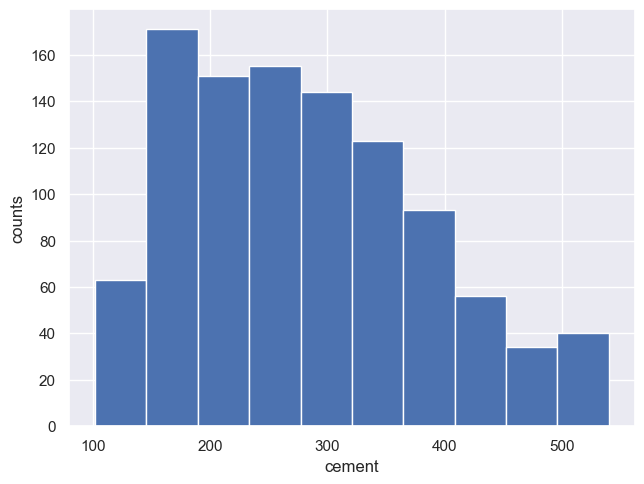

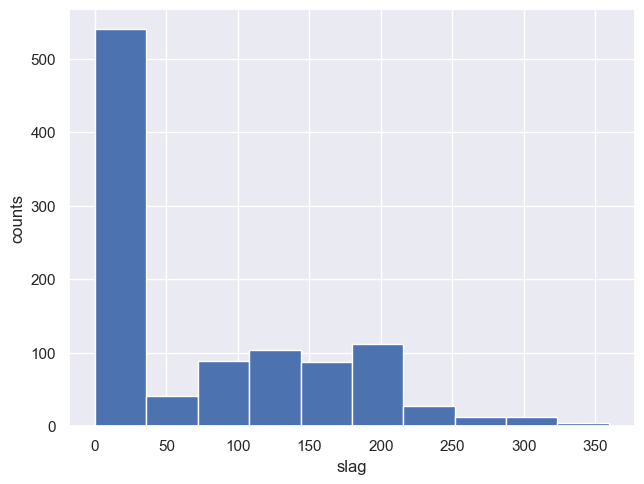

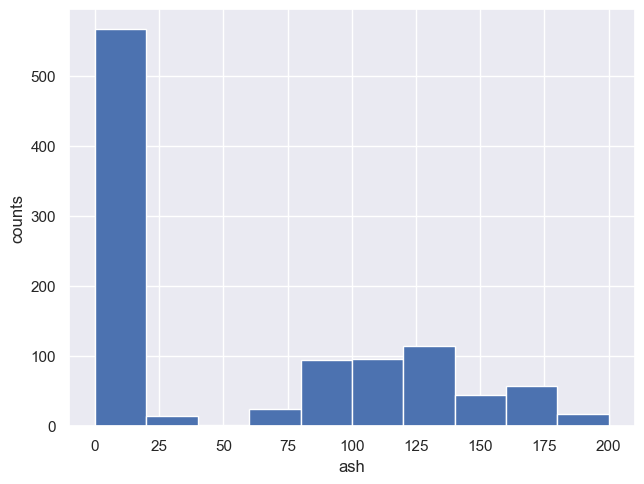

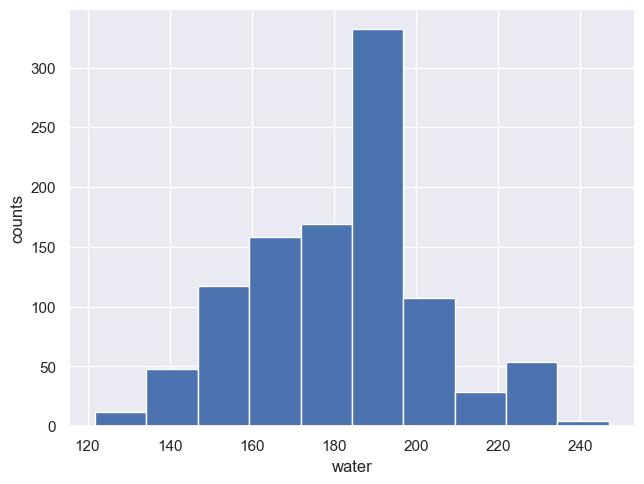

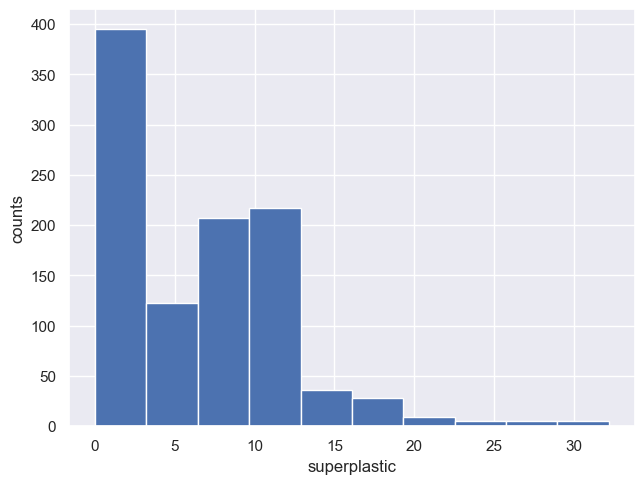

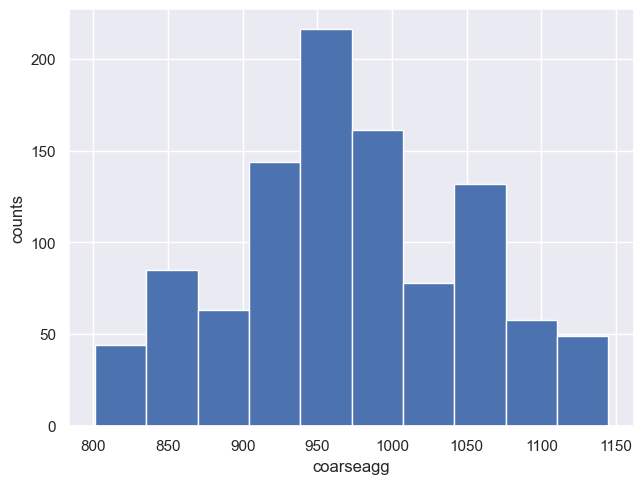

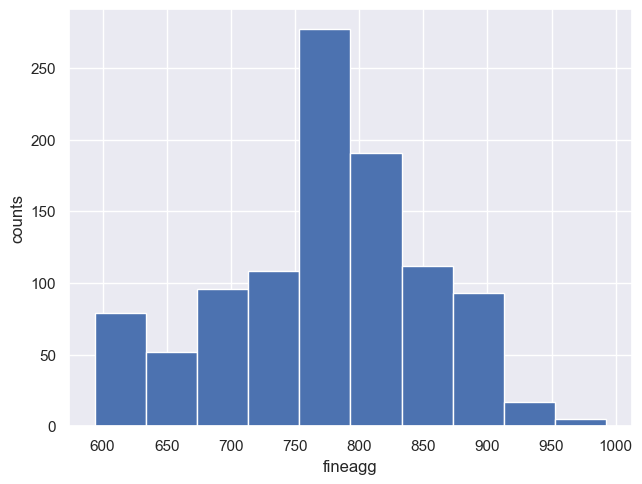

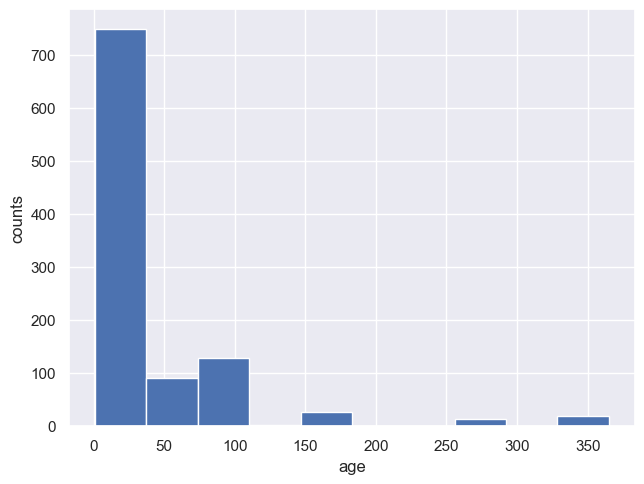

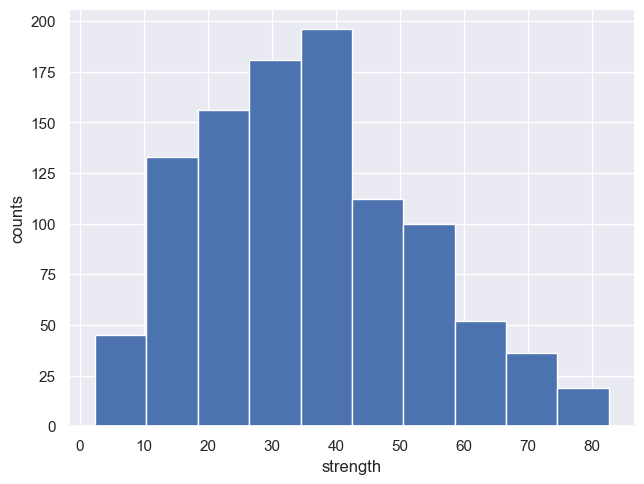

In [76]:
#look at data distribution
for i in concrete_df.columns:
    plt.hist(concrete_df[i])
    plt.tight_layout()
    plt.xticks()
    plt.xlabel(i)
    plt.ylabel('counts')
    plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

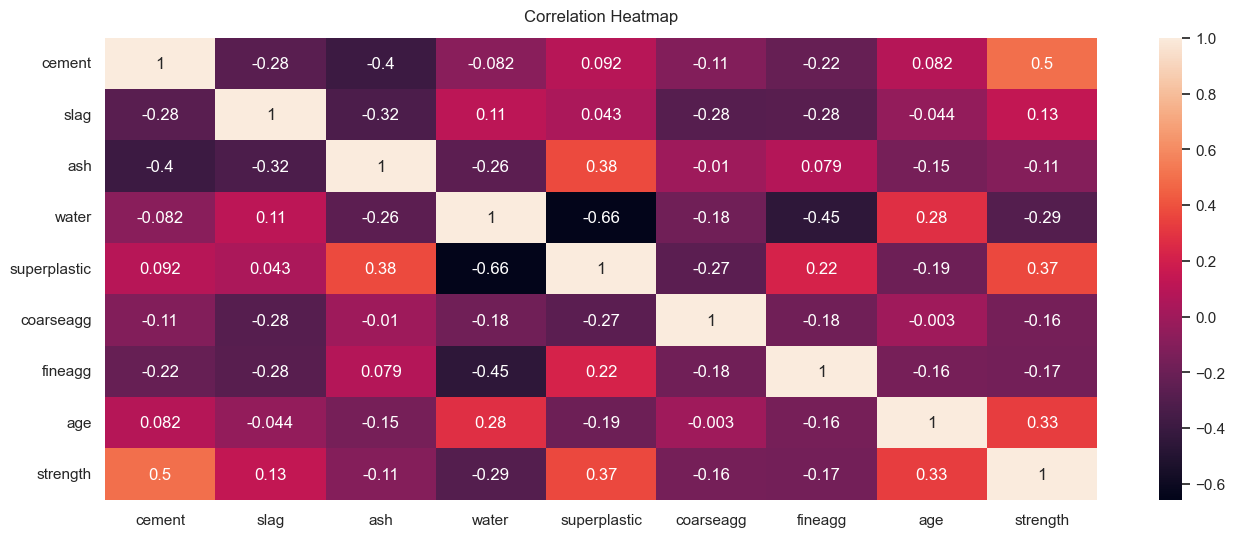

In [77]:
#heat map using Pearson's coefficient
plt.figure(figsize=(16, 6))
sns.heatmap(concrete_df.corr(), annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [78]:
#create bins from strength
bins = pd.qcut(concrete_df['strength'], q=4)

#add bins to concrete df
concrete_df['bins']=bins

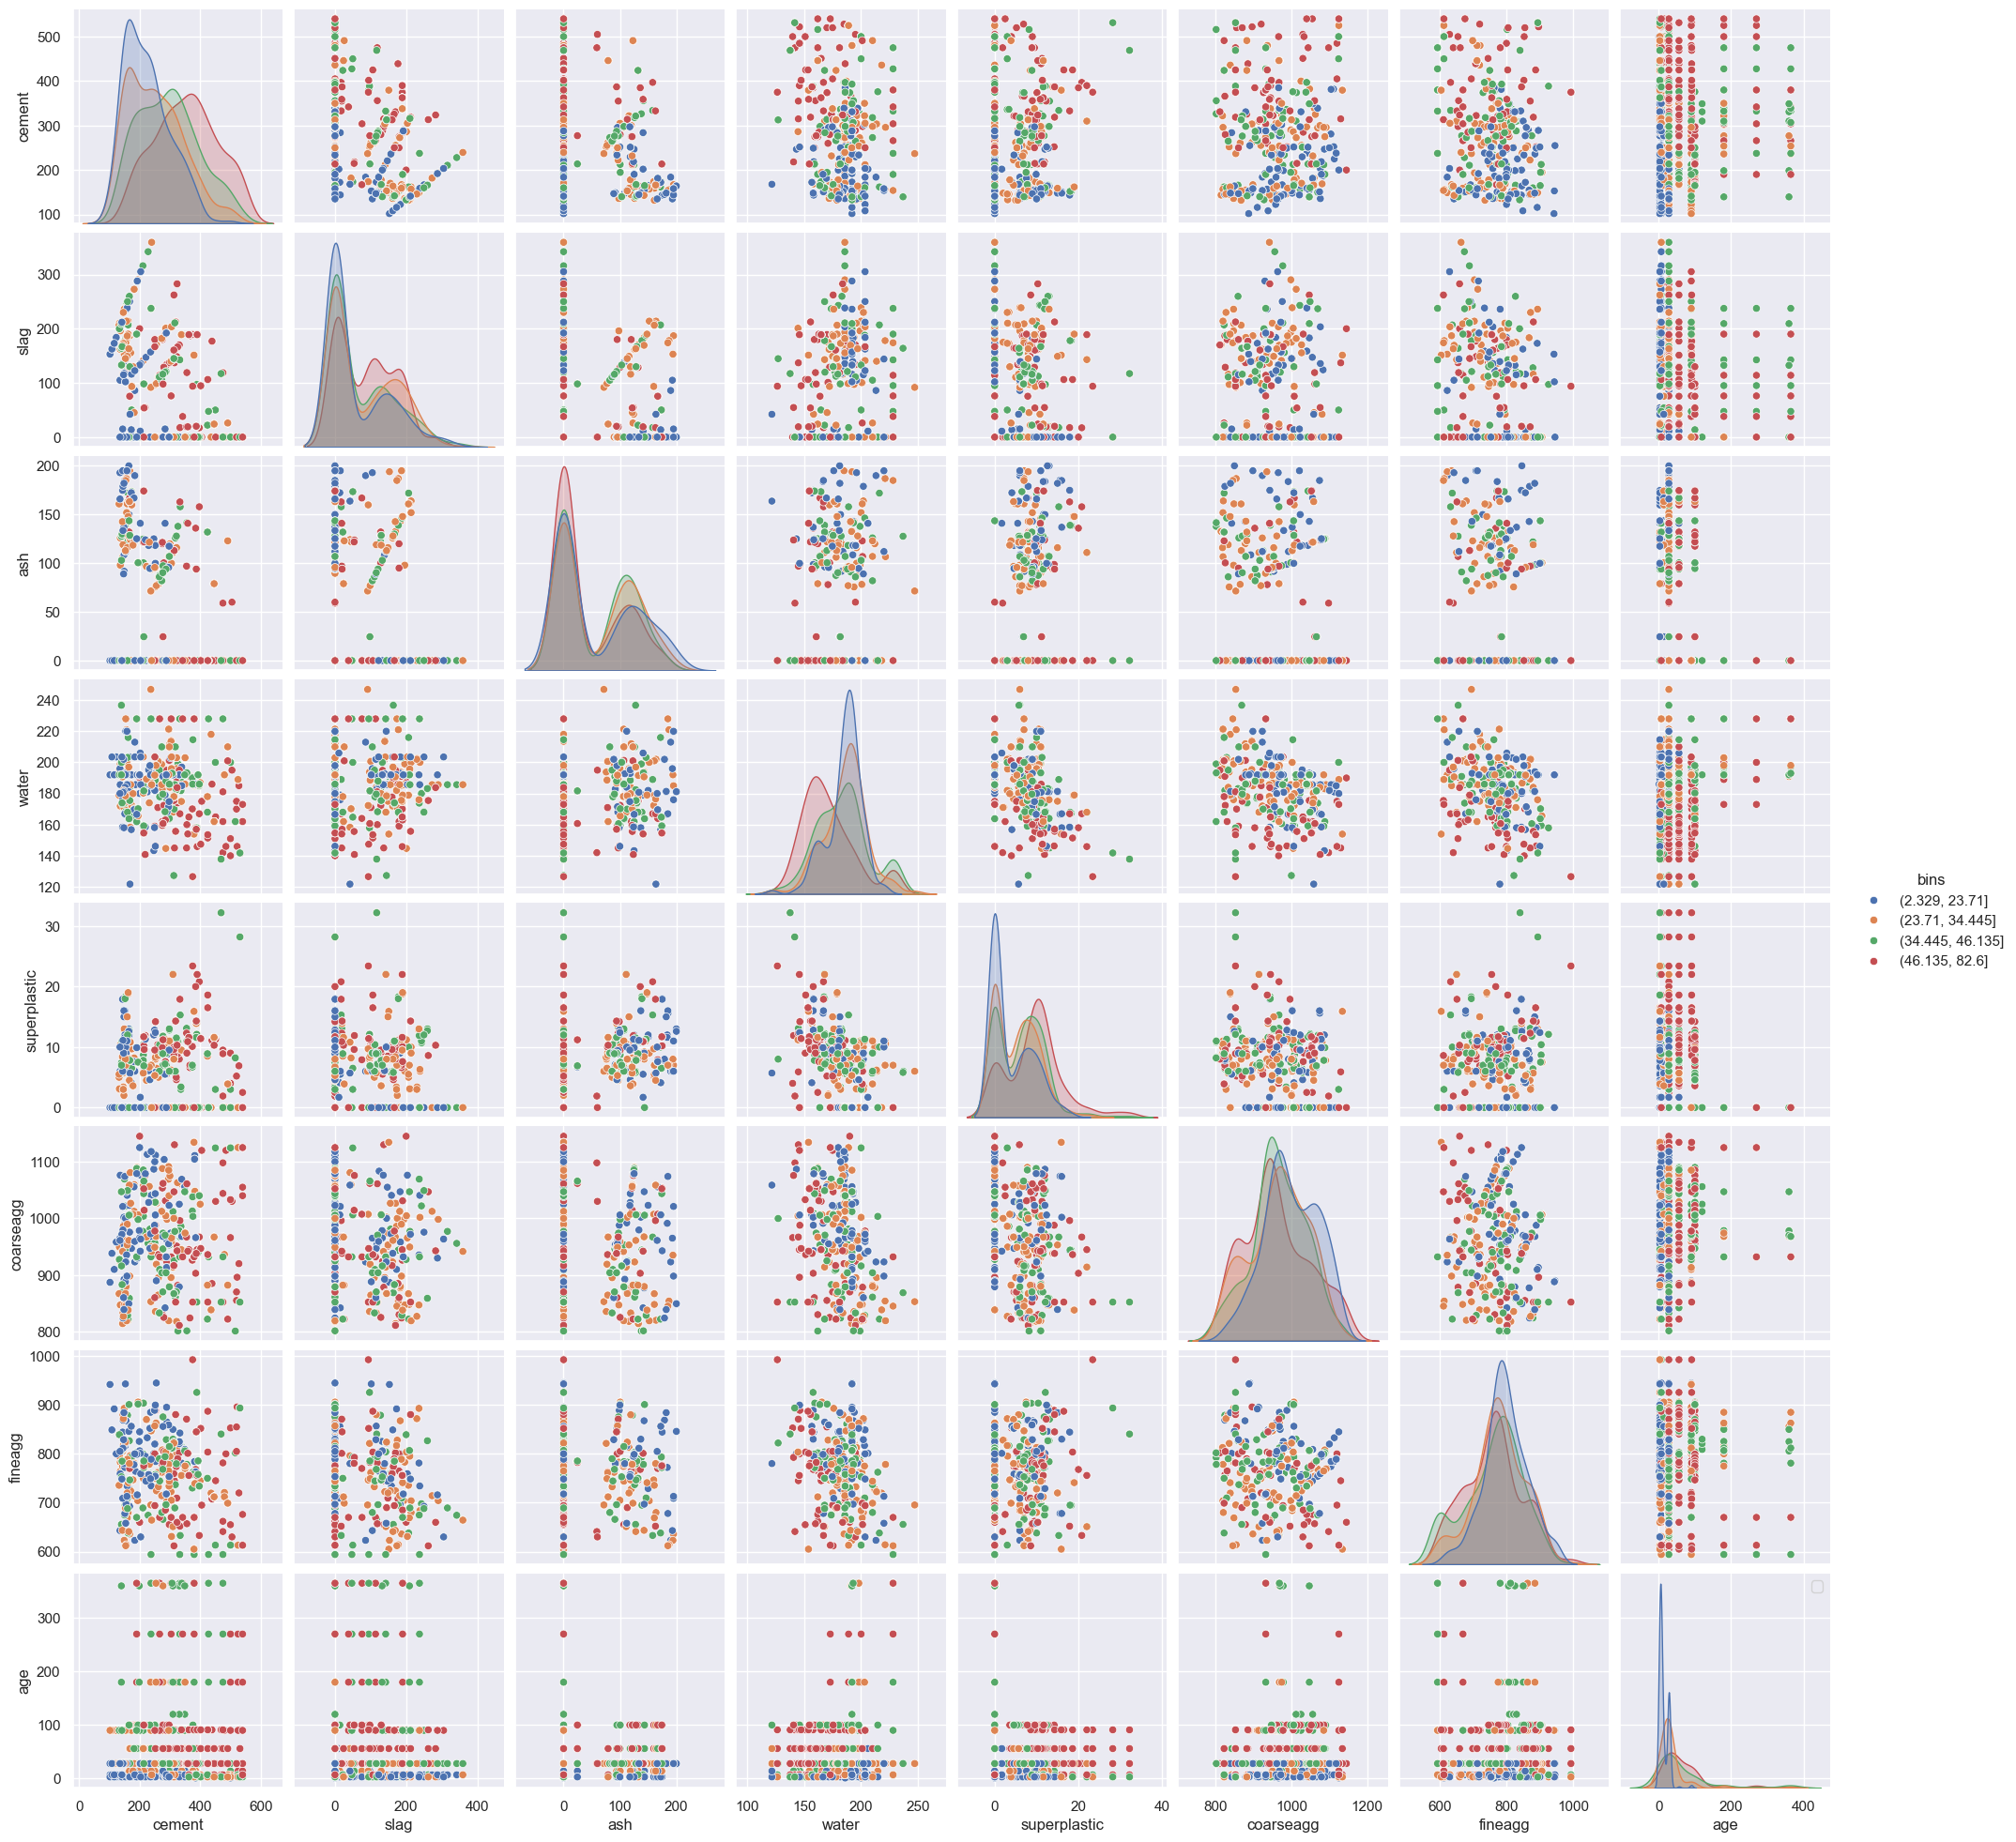

In [79]:
#look at how target is distributed among variables
sns.pairplot(concrete_df.loc[:, (concrete_df.columns != 'strength')], hue='bins')
plt.legend()
plt.show()

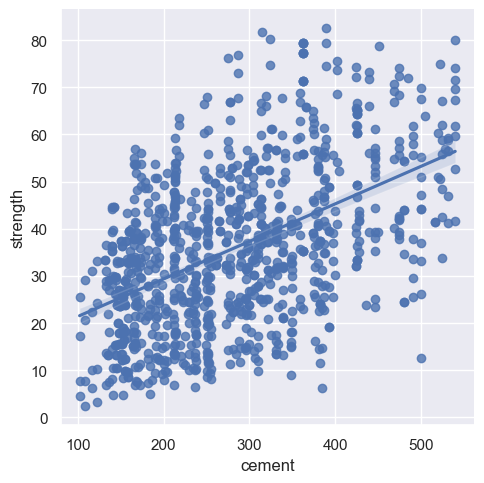

In [80]:
#plot strongest linear correlation
sns.lmplot(x='cement', y='strength',data=concrete_df)
plt.show()

In [81]:
#drop bins from concrete data
concrete_df = concrete_df.drop('bins', axis=1)

In [82]:
#copy of variables and target
X = concrete_df.copy()
y = X.pop('strength')

In [120]:
#make a copy of features matrix for mutual information analysis
X_mutual = X.copy()

#label encoding for categorical variables
for colname in X_mutual.select_dtypes("object"):
    X_mutual[colname], _ = X_mutual[colname].factorize()

#all discrete features have int dtypes
discrete_features = X_mutual.dtypes == object

In [84]:
#some continuous variables also have int dtypes
discrete_features[X_mutual.columns] = False

In [85]:
#use regression since the target variable is continuous
from sklearn.feature_selection import mutual_info_regression

#define a function to produce mutual information scores
def make_mutual_scores(X_mutual, y, discrete_features):
    mutual_scores = mutual_info_regression(X_mutual, y, discrete_features=discrete_features)
    mutual_scores = pd.Series(mutual_scores, name="MI Scores", index=X_mutual.columns)
    mutual_scores = mutual_scores.sort_values(ascending=False)
    return mutual_scores

#compute mutual information scores
mutual_scores = make_mutual_scores(X_mutual, y, discrete_features)
mutual_scores

water           0.359901
age             0.357831
cement          0.306919
coarseagg       0.252867
fineagg         0.214653
superplastic    0.207906
slag            0.179403
ash             0.123301
Name: MI Scores, dtype: float64

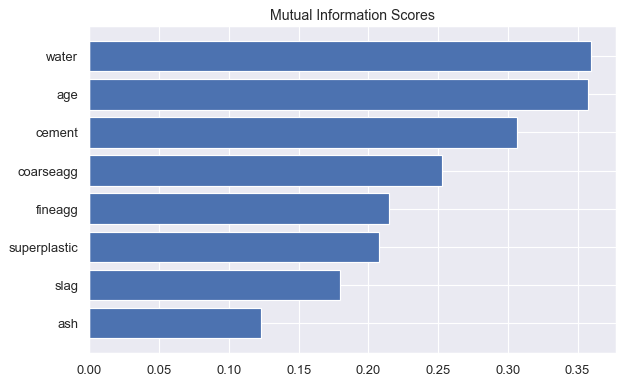

In [86]:
#define a function to plot mutual information scores
def plot_mutual_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

#plot the scores
plt.figure(dpi=85, figsize=(8, 5))
plot_mutual_scores(mutual_scores)

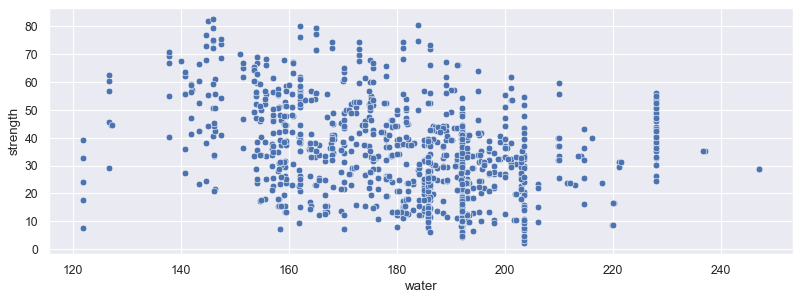

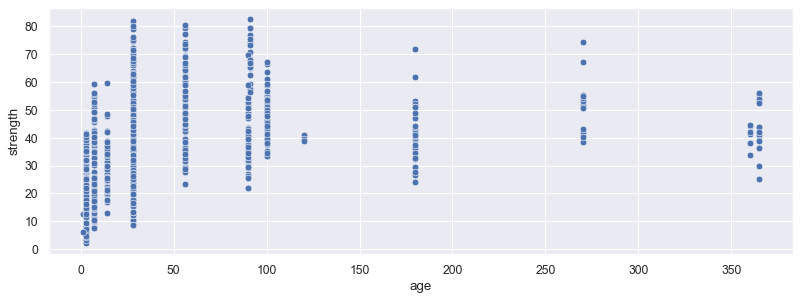

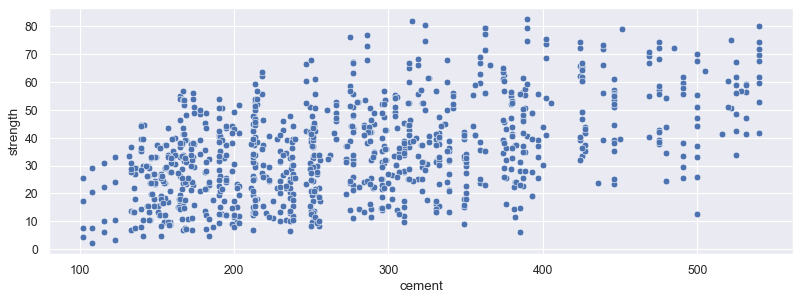

In [87]:
#plot top MI score predictors against target
for i in ['water', 'age', 'cement']:
    fig, ax = plt.subplots(dpi = 80, figsize=(12,4))
    sns.scatterplot(x=X_mutual[i], y=y, ax=ax)
    plt.show()

In [88]:
#copy features matrix for principal component analysis
X_PCA = X.copy()

#standardize
X_PCA_scaled = (X_PCA - X_PCA.mean(axis=0)) / X_PCA.std(axis=0)

from sklearn.preprocessing import StandardScaler
X_PCA_scaled = StandardScaler().fit_transform(X_PCA)

from sklearn.decomposition import PCA
pca = PCA(len(X.columns))  # or PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X_PCA_scaled)

#convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

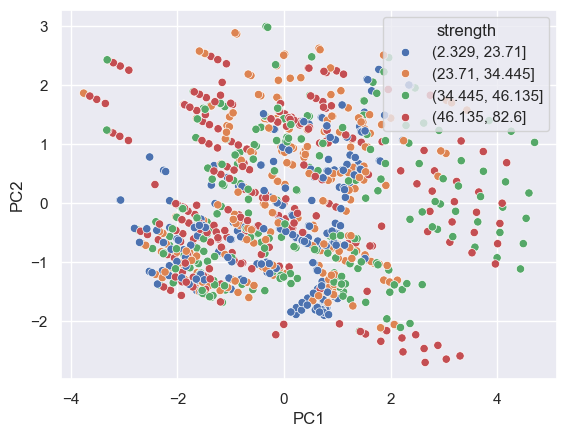

In [89]:
#plot data using principal components
sns.scatterplot(x=X_pca.loc[:,'PC1'],y=X_pca.loc[:,'PC2'], hue=bins)
plt.show()

In [90]:
#determine loadings
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

PC1       PC2       PC3       PC4       PC5       PC6  \
cement        0.098401 -0.113737  0.814202  0.054297 -0.148206 -0.203142   
slag          0.177262  0.686053 -0.171794  0.362699  0.020932  0.304882   
ash          -0.394662 -0.142948 -0.408221 -0.226751 -0.549631 -0.183267   
water         0.547004  0.053256 -0.213190 -0.296060 -0.070222 -0.365970   
superplastic -0.505945  0.282930  0.234597  0.037274 -0.354618  0.193294   
coarseagg     0.037928 -0.629943 -0.174088  0.545805  0.033083  0.314559   
fineagg      -0.401926 -0.019391 -0.004569 -0.385282  0.701237  0.092466   
age           0.291479 -0.125981  0.100521 -0.527919 -0.228010  0.743908   

                   PC7       PC8  
cement       -0.221844  0.446163  
slag         -0.228363  0.437384  
ash          -0.352463  0.381886  
water         0.524275  0.388741  
superplastic  0.664643  0.051750  
coarseagg     0.226840  0.349320  
fineagg       0.039026  0.433370  
age          -0.069367  0.012881

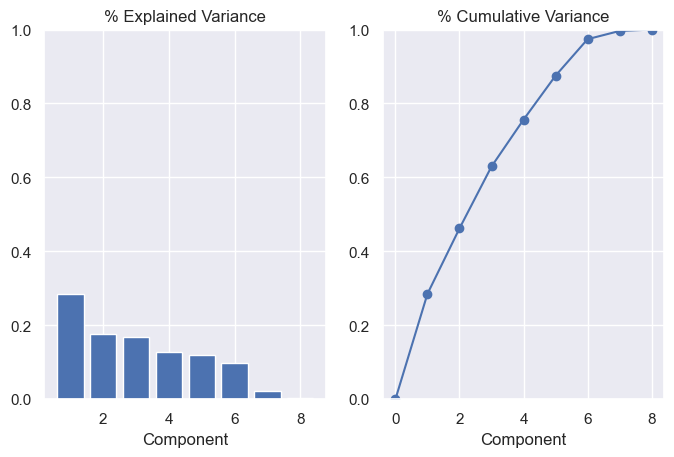

In [91]:
#determine % explained variance and use % cumulative variance for elbow method to determine number of PCs

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca);

In [92]:
#generate OLS regression results for all features
import statsmodels.api as sm

X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     204.3
Date:                Mon, 02 Jun 2025   Prob (F-statistic):          6.29e-206
Time:                        09:56:03   Log-Likelihood:                -3869.0
No. Observations:                1030   AIC:                             7756.
Df Residuals:                    1021   BIC:                             7800.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -23.3312     26.586     -0.878   

In [93]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
#initialize VIF dataframe
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
  
#calculate VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_df)

        feature        VIF
0        cement  15.456717
1          slag   3.329127
2           ash   4.147833
3         water  82.157569
4  superplastic   5.471094
5     coarseagg  84.955779
6       fineagg  72.790995
7           age   1.699459


In [94]:
#print OLS summary for each feature
for i in X.columns:
    X_sm = sm.add_constant(X[i])
    model = sm.OLS(y,X_sm)
    print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     338.7
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           1.32e-65
Time:                        09:56:04   Log-Likelihood:                -4214.6
No. Observations:                1030   AIC:                             8433.
Df Residuals:                    1028   BIC:                             8443.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4425      1.297     10.365      0.0

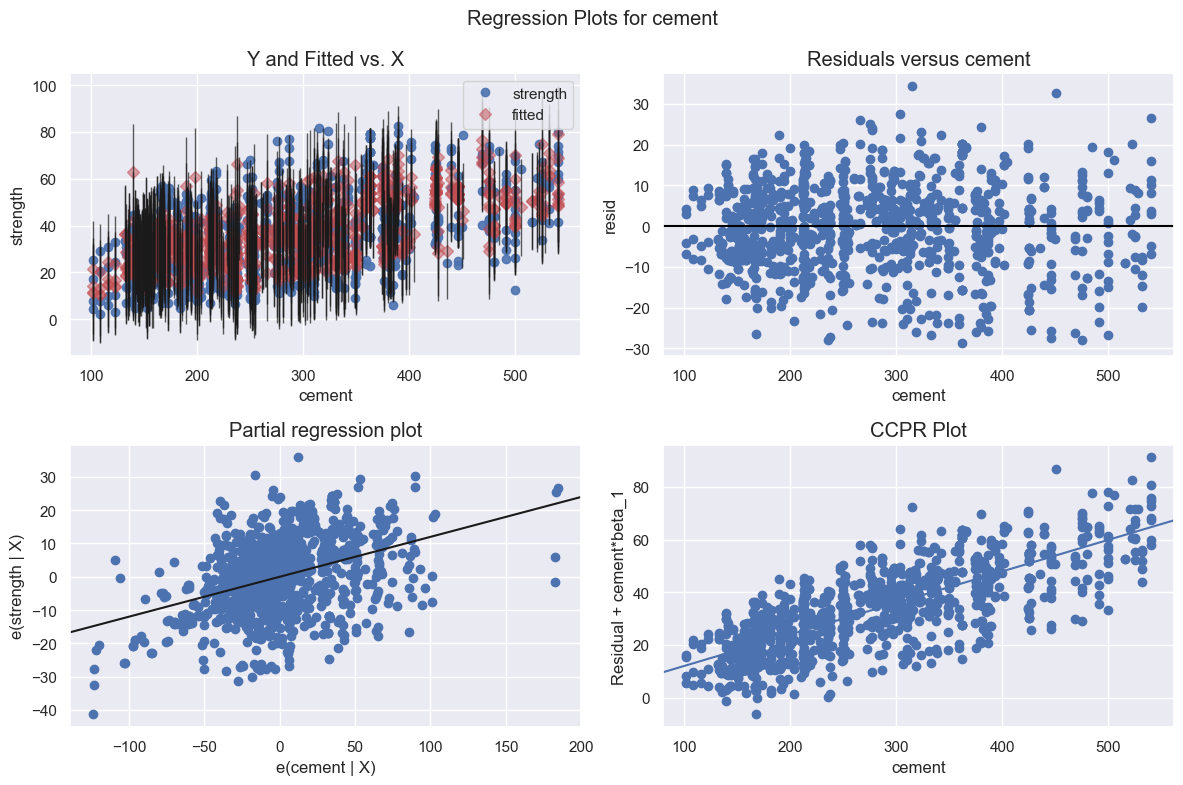

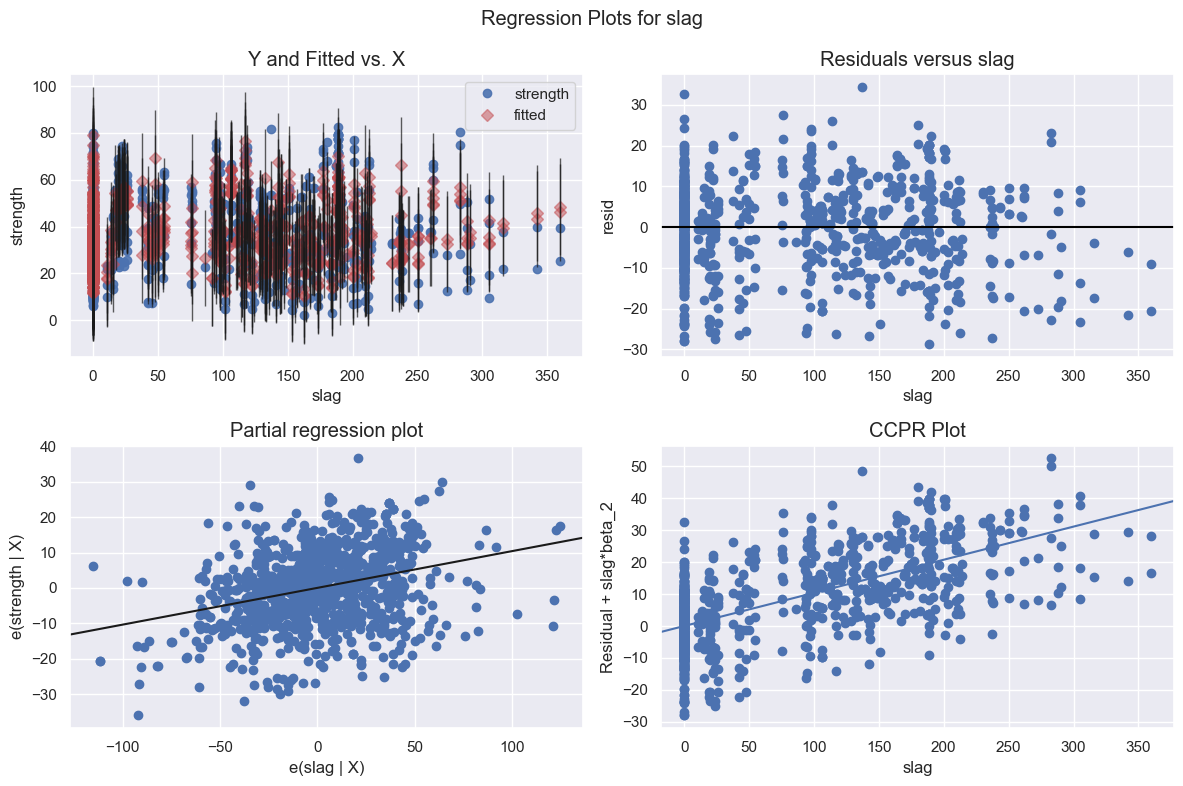

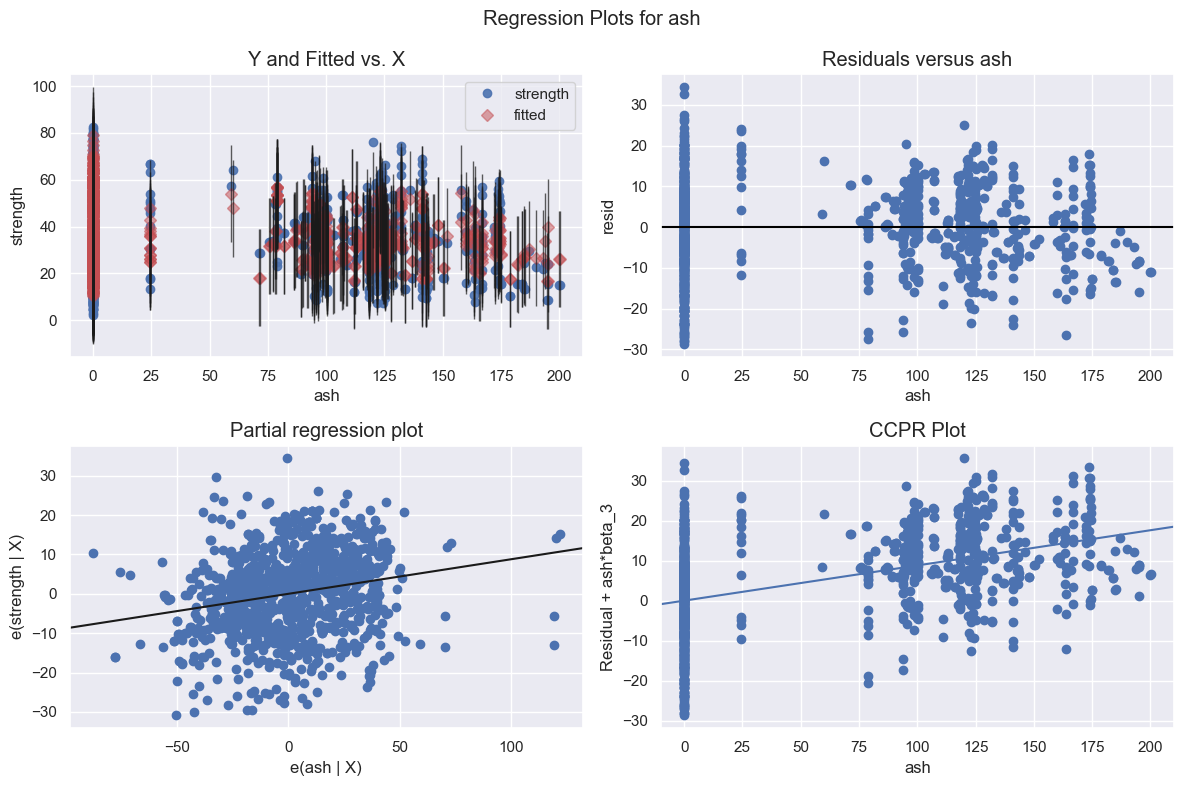

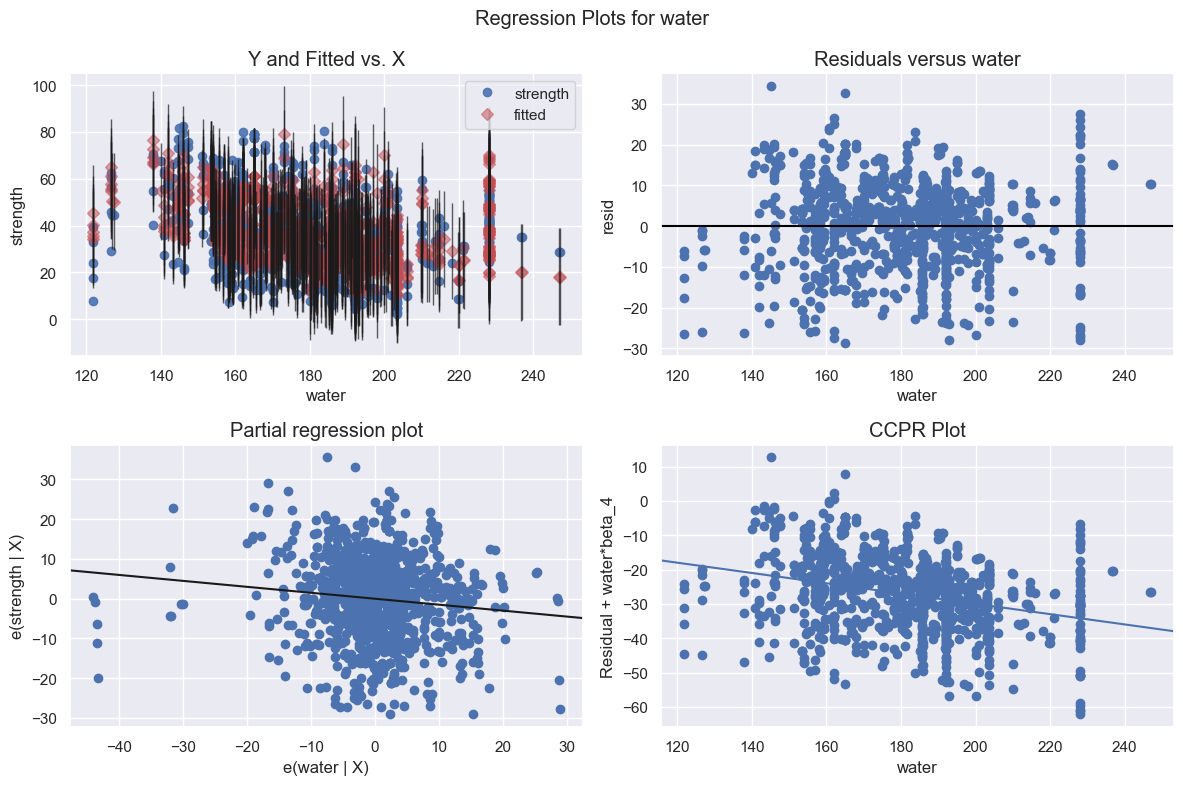

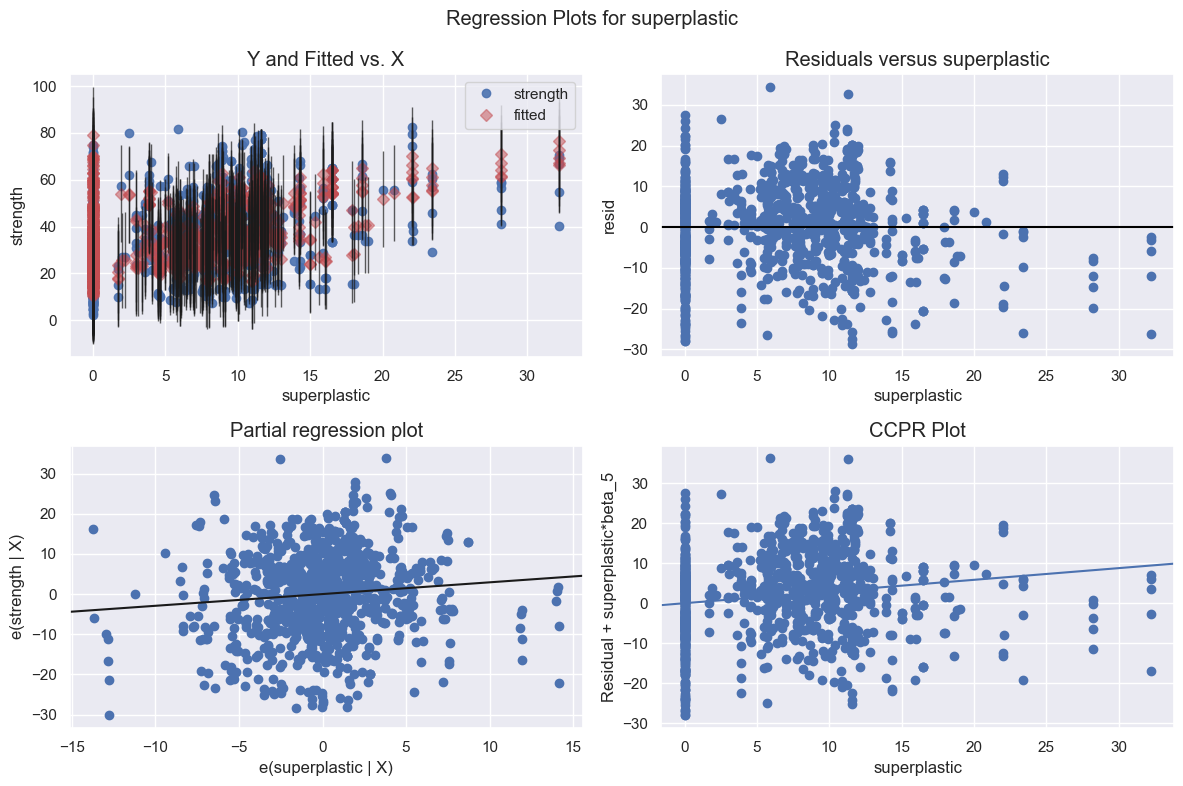

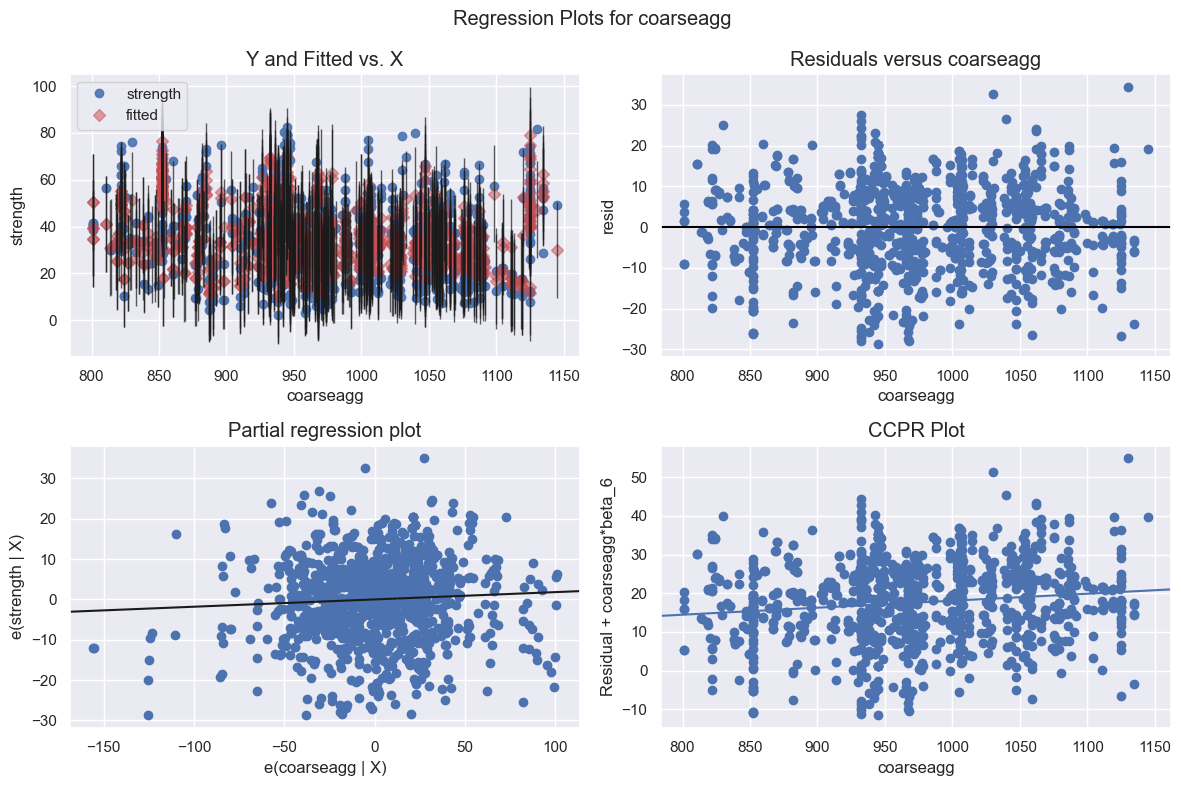

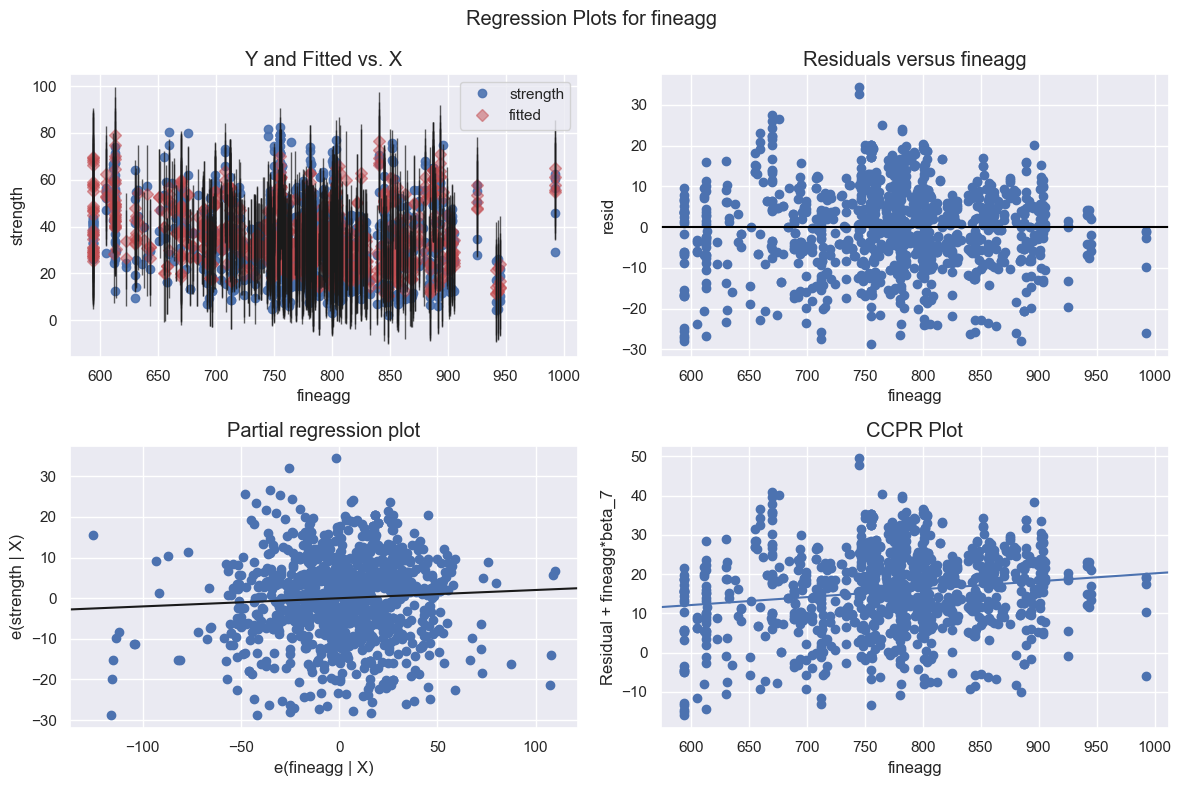

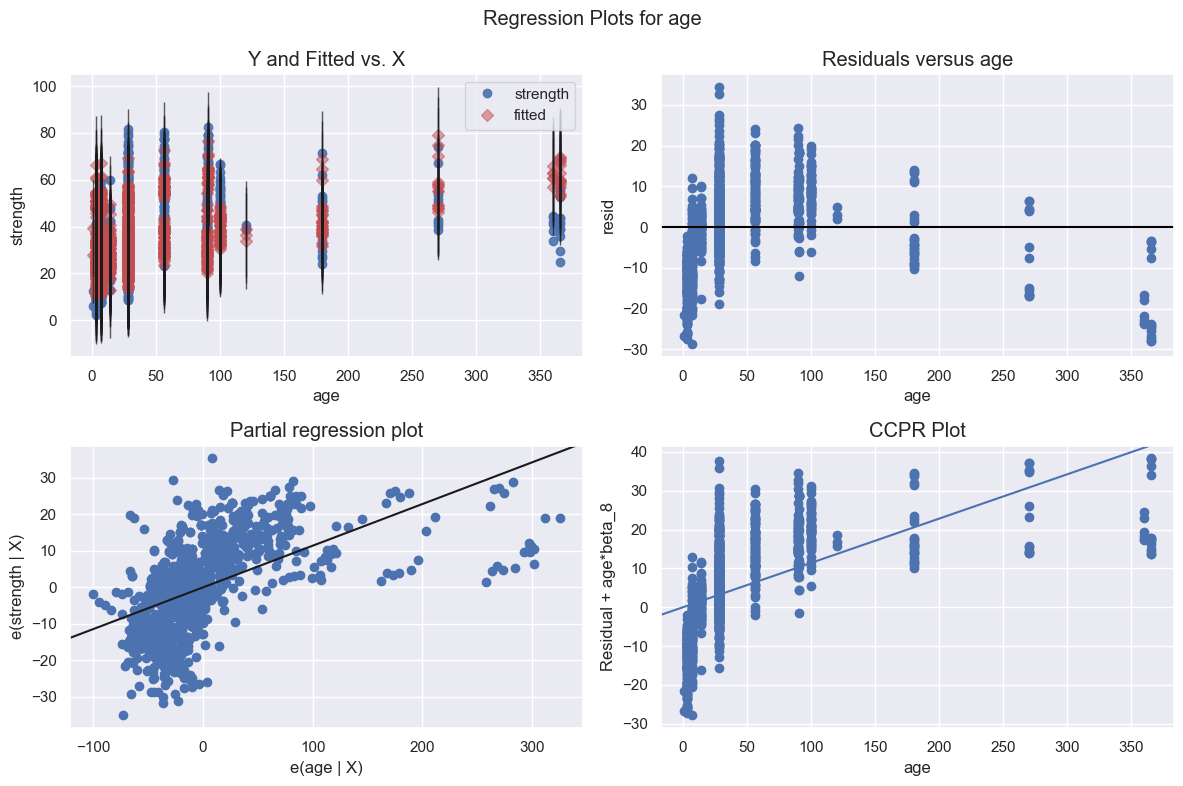

In [95]:
from statsmodels.formula.api import ols

#fit multiple linear regression model
model = ols('strength ~ cement + slag + ash + water + superplastic + coarseagg + fineagg + age', data=concrete_df).fit()

#create residual vs. predictor plot for 'assists'
for i in X.columns:
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(model, i, fig=fig)
    fig.show()

In [96]:
#feature engineering using knowledge that water:cement ratio is an important factor for concrete strength
X['water_cement_ratio'] = X['water']/X['cement']

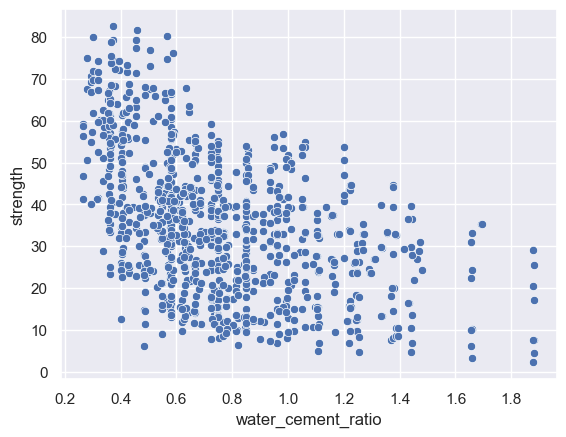

In [97]:
#plot water:cement ratio against compressive strength
sns.scatterplot(x=X['water_cement_ratio'], y=y)
plt.show()

In [98]:
#generate OLS regression results with water : cement ratio
X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     183.6
Date:                Mon, 02 Jun 2025   Prob (F-statistic):          2.28e-206
Time:                        09:56:52   Log-Likelihood:                -3865.2
No. Observations:                1030   AIC:                             7750.
Df Residuals:                    1020   BIC:                             7800.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -16.1769     26

In [99]:
#generate OLS summary with only water : cement ratio
X_sm = sm.add_constant(X['water_cement_ratio'])
model = sm.OLS(y,X_sm)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     343.9
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           1.86e-66
Time:                        09:56:52   Log-Likelihood:                -4212.6
No. Observations:                1030   AIC:                             8429.
Df Residuals:                    1028   BIC:                             8439.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 55.7502      1

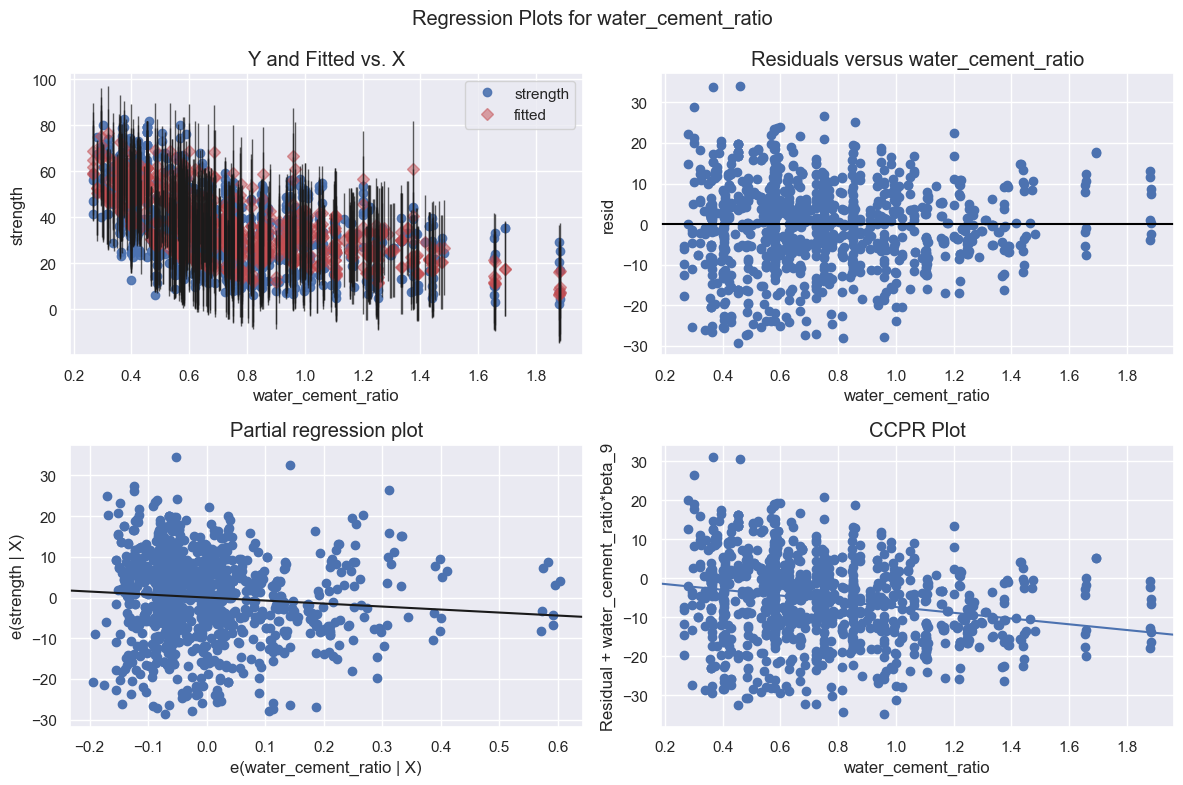

In [100]:
#copy water : cement ratio into concrete data
concrete_df['water_cement_ratio'] = X['water_cement_ratio']

#fit multiple linear regression model with water : cement ratio
model = ols('strength ~ cement + slag + ash + water + superplastic + coarseagg + fineagg + age + water_cement_ratio', data=concrete_df).fit()

#plot regression plots for water : cement ratio
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'water_cement_ratio', fig=fig)
fig.show()

In [101]:
#import ML preprocessing packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [102]:
#column names
feature_names = X.columns

#train/test split 75% training, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=1)

#numerical pipeline
scaler=MinMaxScaler()

#apply scaler to numerical data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [103]:
#import ML packages
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [104]:
#LinearRegression mean cross-validation
lm = LinearRegression()
lm.fit(X_train, y_train)
cv = cross_val_score(lm,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print('LinearRegression')
print(mean(cv), '+/-', std(cv))

LinearRegression
-8.141233606445669 +/- 0.43353405704489945


In [105]:
#RandomForestRegressor mean cross-validation
rf = RandomForestRegressor(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print('RandomForestRegressor')
print(mean(cv), '+/-', std(cv))

RandomForestRegressor
-3.650450050627407 +/- 0.30545883607731705


In [106]:
#GradientBoostingRegressor mean cross-validation
gbr = GradientBoostingRegressor(random_state = 1)
cv = cross_val_score(gbr,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print('GradientBoostingRegressor')
print(mean(cv), '+/-', std(cv))

GradientBoostingRegressor
-3.77279512237311 +/- 0.25519852769863294


In [107]:
#XGBoost mean cross-validation
xgb = XGBRegressor(random_state = 1)
cv = cross_val_score(xgb,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print('XGBoost')
print(mean(cv), '+/-', std(cv))

XGBoost
-3.2619600317556285 +/- 0.14252071668991734


In [108]:
#ml algorithm tuner
from sklearn.model_selection import GridSearchCV

#performance reporting function
def clf_performance(regressor, model_name):
    print(model_name)
    print('Best Score: {} +/- {}'.format(str(regressor.best_score_),str(regressor.cv_results_['std_test_score'][regressor.best_index_])))
    print('Best Parameters: ' + str(regressor.best_params_))

In [109]:
#LinearRegression GridSearchCV
lm = LinearRegression()
param_grid = {
                'fit_intercept':[True,False],
                'positive':[True,False],
                'copy_X':[True, False]
}
clf_lm = GridSearchCV(lm, param_grid = param_grid, cv = 5, scoring='neg_mean_absolute_error', n_jobs = -1)
best_clf_lm = clf_lm.fit(X_train,y_train)
clf_performance(best_clf_lm,'LinearRegressor')

LinearRegressor
Best Score: -8.141233606445667 +/- 0.4335340570448991
Best Parameters: {'copy_X': True, 'fit_intercept': True, 'positive': False}


In [110]:
#RanddomForestRegressor GridSearchCV
rf = RandomForestRegressor(random_state = 1)
param_grid = {
                'n_estimators': np.arange(160,200,2) , 
                'bootstrap': [True,False],
#                 'max_depth': [20,30,40],
#                 'max_features': ['auto','sqrt','log2'],
#                  'min_samples_leaf': [2],
#                  'min_samples_split': [6,8,10]
              }
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, scoring='neg_mean_absolute_error', n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train,y_train)
clf_performance(best_clf_rf,'RandomForestRegressor')

RandomForestRegressor
Best Score: -3.630271832028197 +/- 0.2862728835964901
Best Parameters: {'bootstrap': True, 'n_estimators': 168}


In [119]:
#GradientBoostingRegressor GridSearchCV
gbr = GradientBoostingRegressor(random_state = 1)
param_grid = {
                'n_estimators': [160], 
                'max_depth': [4],
                'max_features': ['sqrt'],
                'learning_rate': np.arange(.1,1,.1),
                'alpha': [0.0001],
                'min_samples_leaf': [2],
                'min_samples_split': np.arange(2,6,1)
              }
clf_gbr = GridSearchCV(gbr, param_grid = param_grid, cv = 5, scoring='neg_mean_absolute_error', n_jobs = -1)
best_clf_gbr = clf_gbr.fit(X_train,y_train)
clf_performance(best_clf_gbr,'GradientBoostingRegressor')

GradientBoostingRegressor
Best Score: -3.206791696487985 +/- 0.17145142184380147
Best Parameters: {'alpha': 0.0001, 'learning_rate': 0.30000000000000004, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 160}


In [112]:
#XGBoost GridSearchCV
xgb = XGBRegressor(random_state = 1)
param_grid = {
              'max_depth': [4],
              'n_estimators': [500]
              }
clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, scoring='neg_mean_absolute_error', n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train,y_train)
clf_performance(best_clf_xgb,'XGBoost')

XGBoost
Best Score: -3.2109993352470263 +/- 0.10999822427138645
Best Parameters: {'max_depth': 4, 'n_estimators': 500}


In [113]:
#import metrics packages
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [114]:
#GradientBoostingRegressor metrics
gbr = GradientBoostingRegressor(alpha = 0.0001,
                                learning_rate= 0.2,
                                max_depth= 4,
                                max_features='sqrt',
                                min_samples_leaf= 2,
                                min_samples_split= 2,
                                n_estimators= 160,
                                random_state = 1)
gbr.fit(X_train,y_train)
tpred_gbr=gbr.predict(X_test)
print('GradientBoostingRegressor')
print('MSE: {}'.format(mean_squared_error(y_test,tpred_gbr)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,tpred_gbr))))
print('MAE: {}'.format(mean_absolute_error(y_test,tpred_gbr)))
print('R-squared: {}'.format(r2_score(y_test,tpred_gbr)))

GradientBoostingRegressor
MSE: 21.237126917237234
RMSE: 4.608375735249593
MAE: 3.110870036042526
R-squared: 0.9300989091710481


In [115]:
#XGBoost metrics
xgb = XGBRegressor(max_depth=4,
                   n_estimators=500,
                   random_state = 1)
xgb.fit(X_train,y_train)
tpred_xgb=xgb.predict(X_test)
print('XGBoost')
print('MSE: {}'.format(mean_squared_error(y_test,tpred_xgb)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,tpred_xgb))))
print('MAE: {}'.format(mean_absolute_error(y_test,tpred_xgb)))
print('R-squared: {}'.format(r2_score(y_test,tpred_xgb)))

XGBoost
MSE: 17.691330960039043
RMSE: 4.206106389529281
MAE: 2.761323143382405
R-squared: 0.9417697442247233


In [116]:
# Import packages for explaining feature importance
import eli5
from eli5.sklearn import PermutationImportance

In [117]:
#permutation importance from xgboost
perm = PermutationImportance(xgb).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = list(feature_names), top=len(feature_names))